<a href="https://colab.research.google.com/github/hadibudhy/fellowship/blob/main/Nur_Hadi_Budhy_Machine_Learning_Practice_Case.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Scenarios

Suppose you are working in a consulting company, you meet with a client who is interested in implementing a data science project for the first time to solve their problem. You are provided with some problems to be solved, just to examine your capabilities :

Dataset link: https://www.kaggle.com/mgmarques/customer-segmentation-and-market-basket-analysis/data

Please select one of the cases above, and make your machine learning model. Do not forget to implement CRISP-DM steps! Please be creative and hopefully, you can implement best coding practices in your codes!

## Data Preprocessing

### Import Library and Load Dataset

In [1]:
# Import Library
import pandas as pd
import numpy as np
import datetime
import math

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.metrics import davies_bouldin_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load Dataset
df_raw = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Fellowship/Online Retail.xlsx')
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
#Check Data Type
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [4]:
# Check missing values
missing_percentage = df_raw.isnull().sum() / df_raw.shape[0] * 100
missing_percentage

InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64

When looking at the number of null values in the data frame, it is interesting that ∼25% of the entries are not assigned to a particular customer. With the data available, it is impossible to impute values for the user and these entries are consequently useless for the current exercise.

### Data Cleaning & Data Wrangling

In [5]:
# Drop customer missing values
df_raw2 = df_raw.copy(deep=True)
df_raw2.dropna(axis = 0, subset = ['CustomerID'], inplace = True)
df_raw2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      406829 non-null object
StockCode      406829 non-null object
Description    406829 non-null object
Quantity       406829 non-null int64
InvoiceDate    406829 non-null datetime64[ns]
UnitPrice      406829 non-null float64
CustomerID     406829 non-null float64
Country        406829 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.9+ MB


As a result of eliminating CostumerId missing values, we now have a data frame that is 100% filled for all variables! 

In [6]:
#Duplicate Entries
print('Entries Duplicate: {}'.format(df_raw2.duplicated().sum()))

Entries Duplicate: 5225


In [7]:
#Drop Duplicate
df_raw3 = df_raw2.copy(deep=True)
df_raw3.drop_duplicates(inplace = True)

#Assign dtype
df_raw3['CustomerID'] = df_raw3['CustomerID'].astype(np.int64)
df_raw3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 401604 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      401604 non-null object
StockCode      401604 non-null object
Description    401604 non-null object
Quantity       401604 non-null int64
InvoiceDate    401604 non-null datetime64[ns]
UnitPrice      401604 non-null float64
CustomerID     401604 non-null int64
Country        401604 non-null object
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 27.6+ MB


In [8]:
df_raw3.describe()

,Quantity,UnitPrice,CustomerID
count,401604.000000,401604.000000,401604.000000
mean,12.183273,3.474064,15281.160818
std,250.283037,69.764035,1714.006089
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13939.000000
50%,5.000000,1.950000,15145.000000
75%,12.000000,3.750000,16784.000000
max,80995.000000,38970.000000,18287.000000


We can see that Quantity has negative values which may indicate that we have some return transactions in our results. Also, UnitPrice has zero value in the preceding output.
We need to delete these records because our target is consumer segmentation and market basket analysis, but first, we'll see if any records are both negative or one that is negative and the other is zero. 

In [9]:
# Check if we had negative quantity and prices at same register
print('Check if we had negative quantity and prices at same register:',
     'No' if df_raw3[(df_raw3.Quantity<0) & (df_raw3.UnitPrice<0)].shape[0] == 0 else 'Yes', '\n')

#Negative Quantity
print('Negative Quantity: {:3.2%}'.format(df_raw3[(df_raw3.Quantity<0)].shape[0]/df_raw3.shape[0]))

#Check register with negative quantity
print('\nAll register with negative quantity has Invoice start with:', 
      df_raw3.loc[(df_raw3.Quantity<0) & ~(df_raw3.CustomerID.isnull()), 'InvoiceNo'].apply(lambda x: x[0]).unique())

Check if we had negative quantity and prices at same register: No 

Negative Quantity: 2.21%

All register with negative quantity has Invoice start with: ['C']


In [10]:
print('Sales records with Customer ID and zero in Unit Price:',df_raw3[(df_raw3.UnitPrice==0)  & ~(df_raw3.CustomerID.isnull())].shape[0])
df_raw3[(df_raw3.UnitPrice==0)  & ~(df_raw3.CustomerID.isnull())]

Sales records with Customer ID and zero in Unit Price: 40


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
9302,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1,2010-12-05 14:02:00,0.0,12647,Germany
33576,539263,22580,ADVENT CALENDAR GINGHAM SACK,4,2010-12-16 14:36:00,0.0,16560,United Kingdom
40089,539722,22423,REGENCY CAKESTAND 3 TIER,10,2010-12-21 13:45:00,0.0,14911,EIRE
47068,540372,22090,PAPER BUNTING RETROSPOT,24,2011-01-06 16:41:00,0.0,13081,United Kingdom
47070,540372,22553,PLASTERS IN TIN SKULLS,24,2011-01-06 16:41:00,0.0,13081,United Kingdom
56674,541109,22168,ORGANISER WOOD ANTIQUE WHITE,1,2011-01-13 15:10:00,0.0,15107,United Kingdom
86789,543599,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,16,2011-02-10 13:08:00,0.0,17560,United Kingdom
130188,547417,22062,CERAMIC BOWL WITH LOVE HEART DESIGN,36,2011-03-23 10:25:00,0.0,13239,United Kingdom
139453,548318,22055,MINI CAKE STAND HANGING STRAWBERY,5,2011-03-30 12:45:00,0.0,13113,United Kingdom
145208,548871,22162,HEART GARLAND RUSTIC PADDED,2,2011-04-04 14:42:00,0.0,14410,United Kingdom


In [11]:
# Remove negative quantity and 0 unit price transactions
df_raw4 = df_raw3.copy(deep=True)
df_raw4 = df_raw4[~(df_raw4.Quantity<0)]
df_raw4 = df_raw4[df_raw4.UnitPrice>0]
df_raw4.describe()

,Quantity,UnitPrice,CustomerID
count,392692.000000,392692.000000,392692.000000
mean,13.119702,3.125914,15287.843865
std,180.492832,22.241836,1713.539549
min,1.000000,0.001000,12346.000000
25%,2.000000,1.250000,13955.000000
50%,6.000000,1.950000,15150.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,8142.750000,18287.000000


In [12]:
# Stock Code and Description Inconsistensies
code_des_df = df_raw4.groupby(['StockCode','Description']).count().reset_index()
display(code_des_df.StockCode.value_counts()[code_des_df.StockCode.value_counts()>1].reset_index().head())

,index,StockCode
0,23196,4
1,23236,4
2,22776,3
3,23244,3
4,23126,3


In [13]:
#Check Multiple Descriptions
df_raw4[df_raw4['StockCode'] == code_des_df.StockCode.value_counts()[code_des_df.StockCode.value_counts()>1].reset_index()['index'][4]]['Description'].unique()

array(['DOLLCRAFT GIRL AMELIE KIT', 'FELTCRAFT GIRL AMELIE KIT',
       'DOLLCRAFT GIRL AMELIE'], dtype=object)

In [14]:
#Make Unique Description
unique_desc = df_raw4[['StockCode', 'Description']].groupby(by=['StockCode']).apply(pd.DataFrame.mode).reset_index(drop=True)

#Handle Multiple Descriptions
df_raw5 = pd.merge(unique_desc,df_raw4,on=['StockCode', 'Description'])
df_raw5.sort_values(by=['InvoiceNo']).head()

,StockCode,Description,InvoiceNo,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
366197,84406B,CREAM CUPID HEARTS COAT HANGER,536365,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
364787,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,536365,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
364464,84029E,RED WOOLLY HOTTIE WHITE HEART.,536365,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
67021,21730,GLASS STAR FROSTED T-LIGHT HOLDER,536365,6,2010-12-01 08:26:00,4.25,17850,United Kingdom
379877,85123A,WHITE HANGING HEART T-LIGHT HOLDER,536365,6,2010-12-01 08:26:00,2.55,17850,United Kingdom


In [15]:
# Add total price feature
df_raw6 = df_raw5.copy(deep=True)
df_raw6['TotalPrice'] = df_raw6.Quantity * df_raw6.UnitPrice
df_raw6.head()

,StockCode,Description,InvoiceNo,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,10002,INFLATABLE POLITICAL GLOBE,536370,48,2010-12-01 08:45:00,0.85,12583,France,40.80
1,10002,INFLATABLE POLITICAL GLOBE,536382,12,2010-12-01 09:45:00,0.85,16098,United Kingdom,10.20
2,10002,INFLATABLE POLITICAL GLOBE,536863,1,2010-12-03 11:19:00,0.85,17967,United Kingdom,0.85
3,10002,INFLATABLE POLITICAL GLOBE,537047,1,2010-12-05 11:02:00,0.85,13069,United Kingdom,0.85
4,10002,INFLATABLE POLITICAL GLOBE,537227,24,2010-12-06 08:42:00,0.85,17677,United Kingdom,20.40


In [16]:
# Drop unrelevant items
remove_items = ['POSTAGE', 'CARRIAGE', 'Manual', 'Bank Charges', 'PADS TO MATCH ALL CUSHIONS', 'DOTCOM POSTAGE']
df = df_raw6[~df_raw6['Description'].isin(remove_items)]
df.head()

,StockCode,Description,InvoiceNo,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,10002,INFLATABLE POLITICAL GLOBE,536370,48,2010-12-01 08:45:00,0.85,12583,France,40.80
1,10002,INFLATABLE POLITICAL GLOBE,536382,12,2010-12-01 09:45:00,0.85,16098,United Kingdom,10.20
2,10002,INFLATABLE POLITICAL GLOBE,536863,1,2010-12-03 11:19:00,0.85,17967,United Kingdom,0.85
3,10002,INFLATABLE POLITICAL GLOBE,537047,1,2010-12-05 11:02:00,0.85,13069,United Kingdom,0.85
4,10002,INFLATABLE POLITICAL GLOBE,537227,24,2010-12-06 08:42:00,0.85,17677,United Kingdom,20.40


## Exploratory Data Analysis

This dataframe contains 8 variables that correspond to:

**InvoiceNo**: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. 

**StockCode**: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.

**Description**: Product (item) name. Nominal.

**Quantity**: The quantities of each product (item) per transaction. Numeric.

**InvoiceDate**: Invice Date and time. Numeric, the day and time when each transaction was generated.

**UnitPrice**: Unit price. Numeric, Product price per unit in sterling.

**CustomerID**: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.

**Country**: Country name. Nominal, the name of the country where each customer resides.

**TotalPrice**: Price Total. Numeric, Unit Price * Quantity in sterling.


In [17]:
g = df.groupby(['Country']).TotalPrice.sum().sort_values(ascending = False)
fig = px.bar(g, x=g.index, y='TotalPrice', title='Amount Sales by Country')
fig.show()

In [18]:
df['Local'] = df.Country.apply(lambda x: 'Yes (UK)' if x=='United Kingdom' else 'No (Outside UK)' )
market = df.groupby(['Local']).TotalPrice.sum().sort_values(ascending = False)
fig = px.pie(market, values='TotalPrice', names=market.index, title='Local Market')
fig.show()

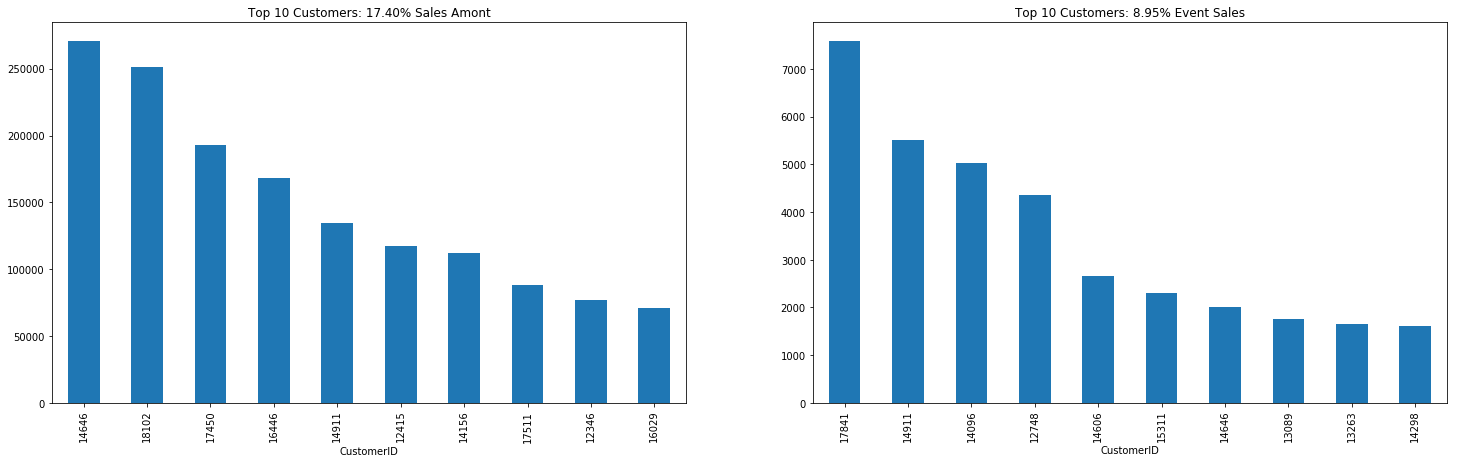

In [19]:
fig = plt.figure(figsize=(25, 7))
f1 = fig.add_subplot(121)
PercentSales =  np.round((df.groupby(['CustomerID']).TotalPrice.sum().\
                          sort_values(ascending = False)[:10].sum()/df.groupby(['CustomerID']).\
                          TotalPrice.sum().sort_values(ascending = False).sum()) * 100, 2)
g = df.groupby(['CustomerID']).TotalPrice.sum().sort_values(ascending = False)[:10]\
    .plot(kind='bar', title='Top 10 Customers: {:3.2f}% Sales Amont'.format(PercentSales))
f1 = fig.add_subplot(122)
PercentSales =  np.round((df.groupby(['CustomerID']).TotalPrice.count().\
                          sort_values(ascending = False)[:10].sum()/df.groupby(['CustomerID']).\
                          TotalPrice.count().sort_values(ascending = False).sum()) * 100, 2)
g = df.groupby(['CustomerID']).TotalPrice.count().sort_values(ascending = False)[:10].\
    plot(kind='bar', title='Top 10 Customers: {:3.2f}% Event Sales'.format(PercentSales))

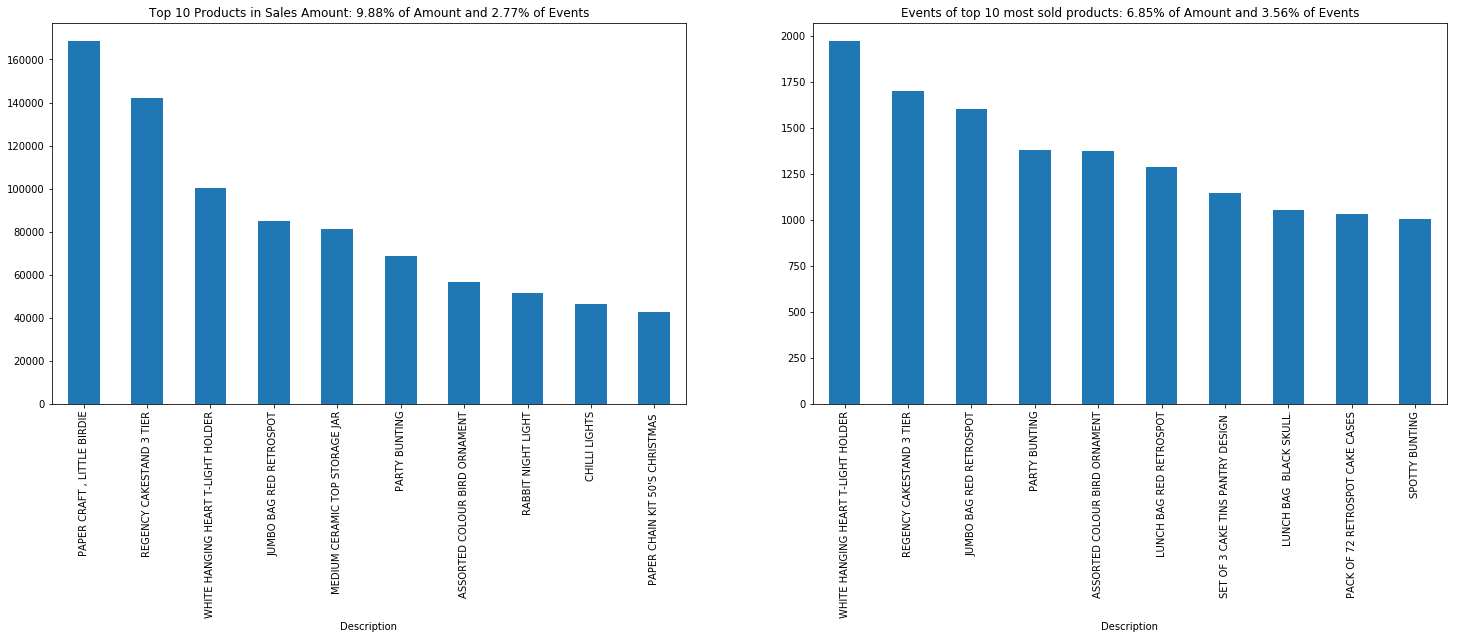

In [20]:
AmountSum = df.groupby(['Description']).TotalPrice.sum().sort_values(ascending = False)
inv = df[['Description', 'InvoiceNo']].groupby(['Description']).InvoiceNo.unique().\
      agg(np.size).sort_values(ascending = False)

fig = plt.figure(figsize=(25, 7))
f1 = fig.add_subplot(121)
Top10 = list(AmountSum[:10].index)
PercentSales =  np.round((AmountSum[Top10].sum()/AmountSum.sum()) * 100, 2)
PercentEvents = np.round((inv[Top10].sum()/inv.sum()) * 100, 2)
g = AmountSum[Top10].\
    plot(kind='bar', title='Top 10 Products in Sales Amount: {:3.2f}% of Amount and {:3.2f}% of Events'.\
                       format(PercentSales, PercentEvents))

f1 = fig.add_subplot(122)
Top10Ev = list(inv[:10].index)
PercentSales =  np.round((AmountSum[Top10Ev].sum()/AmountSum.sum()) * 100, 2)
PercentEvents = np.round((inv[Top10Ev].sum()/inv.sum()) * 100, 2)
g = inv[Top10Ev].\
    plot(kind='bar', title='Events of top 10 most sold products: {:3.2f}% of Amount and {:3.2f}% of Events'.\
                       format(PercentSales, PercentEvents))


### Correlation Between Variables

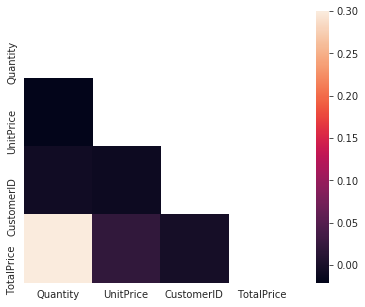

In [21]:
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style('white'):
    f, ax = plt.subplots(figsize=(7, 5))
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True)

## Feature Selection & Feature Engineering

Since our dataset is limited to the sales records and didn´t include another's information about our customers, we will use an RFM,*Recency, Frequency and Monetary Value, based model of customer value for finding our customer segments. The RFM model will take the transactions of a customer and calculate three important informational attributes about each customer:

* **Recency**: The value of how recently a customer purchased at the establishment
* **Frequency**: How frequent the customer’s transactions are at the establishment
* **Monetary value**: The dollar (or pounds in our case) value of all the transactions that the customer made at the establishment


Recency

To create the recency feature variable, we need to decide the reference date for our analysis. Usually, we make use of the last transaction date plus one day. Then, we will construct the recency variable as the number of days before the reference date when a customer last made a purchase.

In [22]:
refrence_date = df.InvoiceDate.max() + datetime.timedelta(days = 1)
print('Reference Date:', refrence_date)
df['days_since_last_purchase'] = (refrence_date - df.InvoiceDate).astype('timedelta64[D]')
cust_df =  df[['CustomerID', 'days_since_last_purchase']].groupby('CustomerID').min().reset_index()
cust_df.rename(columns={'days_since_last_purchase':'recency'}, inplace=True)
cust_df.describe().transpose()

Reference Date: 2011-12-10 12:50:00


,count,mean,std,min,25%,50%,75%,max
CustomerID,4330.0,15299.184988,1721.798056,12346.0,13812.25,15297.5,16778.75,18287.0
recency,4330.0,92.534411,100.013165,1.0,18.00,51.0,142.00,374.0


Frequency

In [23]:
customer_freq = (df[['CustomerID', 'InvoiceNo']].groupby(['CustomerID', 'InvoiceNo']).count().reset_index()).\
                groupby(['CustomerID']).count().reset_index()
customer_freq.rename(columns={'InvoiceNo':'frequency'},inplace=True)
cust_df = cust_df.merge(customer_freq)
cust_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CustomerID,4330.0,15299.184988,1721.798056,12346.0,13812.25,15297.5,16778.75,18287.0
recency,4330.0,92.534411,100.013165,1.0,18.00,51.0,142.00,374.0
frequency,4330.0,4.238337,7.612345,1.0,1.00,2.0,5.00,206.0


Monetary Value

In [24]:
customer_monetary_val = df[['CustomerID', 'TotalPrice']].groupby('CustomerID').sum().reset_index()
customer_monetary_val.rename(columns={'TotalPrice':'monetary'},inplace=True)
cust_df = cust_df.merge(customer_monetary_val)
cust_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CustomerID,4330.0,15299.184988,1721.798056,12346.00,13812.2500,15297.500,16778.75,18287.00
recency,4330.0,92.534411,100.013165,1.00,18.0000,51.000,142.00,374.00
frequency,4330.0,4.238337,7.612345,1.00,1.0000,2.000,5.00,206.00
monetary,4330.0,1969.762861,8681.165888,3.75,300.0425,655.665,1595.36,271072.69


Standardize the data

In [25]:
cust_df['recency_log'] = cust_df['recency'].apply(math.log)
cust_df['frequency_log'] = cust_df['frequency'].apply(math.log)
cust_df['monetary_log'] = cust_df['monetary'].apply(math.log)
feature_vector = ['monetary_log', 'recency_log','frequency_log']
X_subset = cust_df[feature_vector] #.as_matrix()
scaler = preprocessing.StandardScaler().fit(X_subset)
X_scaled = scaler.transform(X_subset)
pd.DataFrame(X_scaled, columns=X_subset.columns).describe().T

,count,mean,std,min,25%,50%,75%,max
monetary_log,4330.0,3.110932e-16,1.000115,-4.172472,-0.680183,-0.057201,0.651435,4.743908
recency_log,4330.0,-4.851857e-17,1.000115,-2.631069,-0.612673,0.114591,0.829669,1.505939
frequency_log,4330.0,-3.517843e-17,1.000115,-1.044491,-1.044491,-0.273201,0.746390,4.884034


## Data Modelling

### Clustering Customers

In [26]:
# compute SSE each K
sse = []
K = range(1,11)
for k in K:
    kMeansModel = KMeans(n_clusters=k).fit(cust_df)
    clusters = kMeansModel.labels_
    sse.append(kMeansModel.inertia_)

Text(0.5, 1.0, 'Elbow Method')

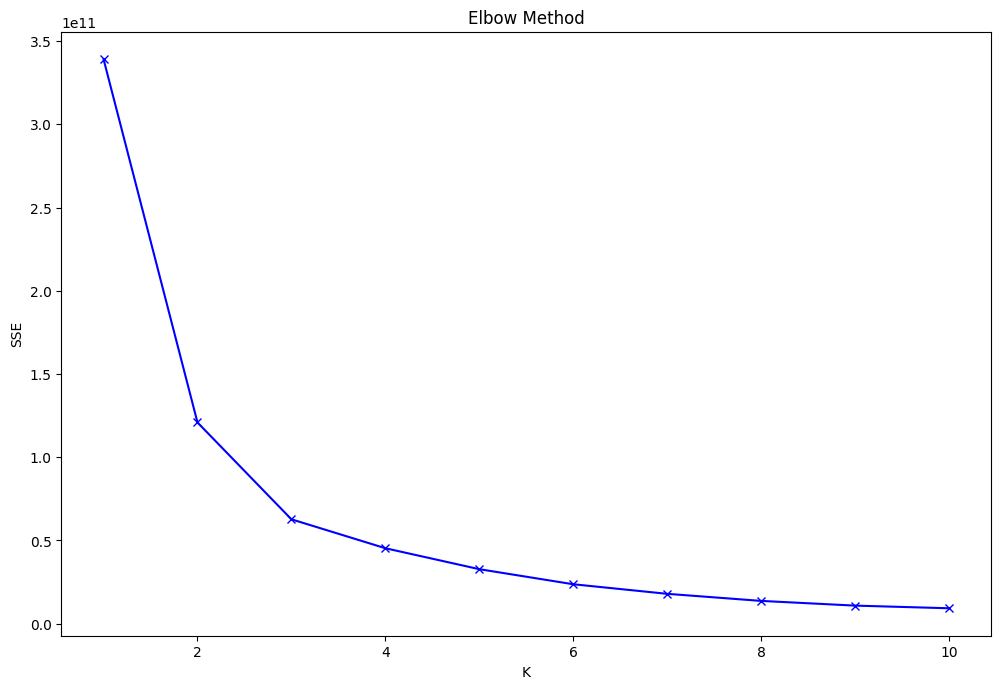

In [27]:
# plot the SSE for elbow method
fig = plt.figure(figsize=(12, 8), dpi=100)
plt.plot(K, sse, 'bx-')
plt.xlabel('K')
plt.ylabel('SSE')
plt.title('Elbow Method')

In [28]:
kmeans_model = KMeans(n_clusters=3)
labels = kmeans_model.fit_predict(cust_df)

In [29]:
cust_df['clusters'] = labels
cust_df.head()

,CustomerID,recency,frequency,monetary,recency_log,frequency_log,monetary_log,clusters
0,12346,326.0,1,77183.60,5.786897,0.000000,11.253942,2
1,12347,2.0,7,4242.50,0.693147,1.945910,8.352908,0
2,12348,75.0,4,1437.24,4.317488,1.386294,7.270480,0
3,12349,19.0,1,1412.55,2.944439,0.000000,7.253152,0
4,12350,310.0,1,294.40,5.736572,0.000000,5.684939,0


In [30]:
fig = px.box(cust_df, y='recency', x='clusters', title='Recency Boxplot')
fig.show()

In [31]:
fig = px.box(cust_df, y='frequency', x='clusters', title='Frequency Boxplot')
fig.show()

In [32]:
fig = px.box(cust_df, y='monetary', x='clusters', title='Monetary Boxplot')
fig.show()

## Model Evaluation

In [33]:
# validation using DBI
davies_bouldin_score(cust_df, labels)

0.38663749549235477